In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import math

In [2]:
class TrackingSegment:
    
    def __init__(self, radius, begin, end):
        self.radius = radius
        self.begin = begin
        self.end = end
        self.hit = False
        t = np.linspace(self.begin, self.end, 100)
        self.x = self.radius*np.cos(t)
        self.y = self.radius*np.sin(t)
        
        
    def check_hit(self, particle):
        d=math.sqrt(particle.x**2 + particle.y**2)
        a=(self.radius**2-particle.radius**2+d**2)/(2*d)
        h=math.sqrt(abs(self.radius**2-a**2))
        x2=a*(particle.x)/d   
        y2=a*(particle.y)/d   
        x3=x2+h*(particle.y)/d     
        y3=y2-h*(particle.x)/d 

        x4=x2-h*(particle.y)/d
        y4=y2+h*(particle.x)/d
        
        rho = math.sqrt(x4**2 + y4**2)
        theta = np.arctan2(x4,y4)
        
        #print(theta, self.begin, self.end)
        if theta > self.begin and theta < self.end:
            self.hit = True
        else:
            self.hit = False
        #print(self.hit)
        return x4, y4
    
    def draw(self, ax):
        ax.plot(self.x,self.y, color = self.check_color(), linewidth = 4)
        return 
        
    def check_color(self):
        if self.hit:
            return "green"
        else:
            return "black"

In [3]:
class ECLSegment:
    def __init__(self, radius, begin, end, width):
        self.radius = radius
        self.begin = begin
        self.end = end
        self.width = width
        self.hit = False
        
    def check_hit(self, particle):
        pass
    
    def draw(self, ax):
        t = np.linspace(self.begin, self.end, 100)
        x = self.radius*np.cos(t)
        y = self.radius*np.sin(t)
        ax.plot(x,y, color = self.check_color())
        x_ = (self.radius+self.width)*np.cos(t)
        y_ = (self.radius+self.width)*np.sin(t)
        ax.plot(x_,y_, color = self.check_color())
        ax.plot([x[0], x_[0]], [y[0], y_[0]], color = self.check_color())
        ax.plot([x[-1], x_[-1]], [y[-1], y_[-1]], color = self.check_color())
        return 
        
    def check_color(self):
        if self.hit:
            return "green"
        else:
            return "black"

In [4]:
class Tracking:
    def __init__(self, layers, n_segments):
        self.n_segments = n_segments
        self.layers = []
        for l in range(layers):
            self.layers.append([])
            len_segment = 2*np.pi/(n_segments+2*l)
            for i in range(n_segments+2*l):
                self.layers[l].append(TrackingSegment((l+1)/2, len_segment*i+(0.2/(l+1)), len_segment*(i+1)-(0.2)/(l+1)))
        self.ecl = []
        l = len(self.layers)
        len_segment = 2*np.pi/(n_segments+2*l)
        for i in range(n_segments+2*l):
            self.ecl.append(ECLSegment((l+1)/2, len_segment*i+(0.2/(l+1)), len_segment*(i+1)-(0.2)/(l+1), width = 1))

    def draw(self, ax, particle):
        for l in self.layers:
            for s in l:
                s.check_hit(particle)
                s.draw(ax)
        for e in self.ecl:
            e.draw(ax)

In [5]:
class Particle:
    def __init__(self,r, phi):
        self.x = r*np.cos(phi)
        self.y = r*np.sin(phi)
        self.radius = r
        self.phi = phi
    
    def draw(self, ax):
        self.x = self.radius*np.cos(self.phi)
        self.y = self.radius*np.sin(self.phi)
        theta = np.linspace(0,np.pi,100)
        x = self.radius*np.cos(theta+self.phi)+self.x
        y = self.radius*np.sin(theta+self.phi)+self.y
        c = "blue" if self.radius<0 else "red"
        ax.plot(x,y,color = c)

interactive(children=(FloatSlider(value=5.0, description='r', max=5.0, min=-5.0), FloatSlider(value=0.0, descr…

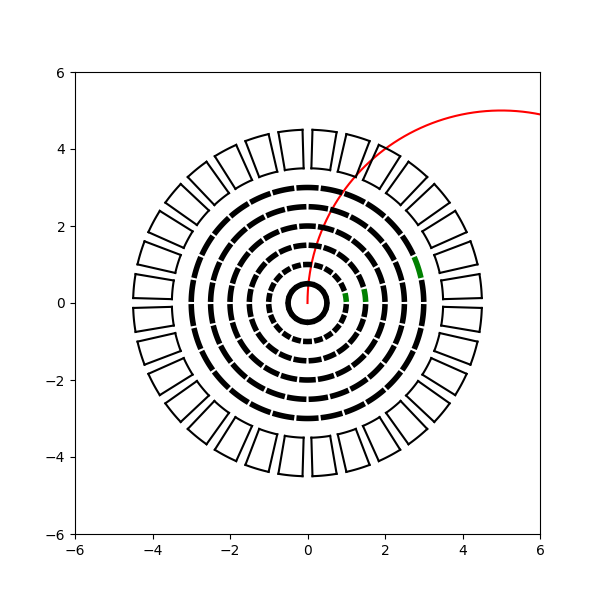

In [6]:
# set up plot
fig, ax = plt.subplots(figsize=(6,6))
ax.set_ylim([-6,6])
ax.set_xlim([-6,6])

# generate x values
x = np.linspace(0, 2 * np.pi, 100)
 
tracking = Tracking(6,20)
particle = Particle(10,0)
 
@widgets.interact(phi = (-np.pi,np.pi, 0.1), r = (-5,5,0.1))

def update(r=10, phi = 0):
    """Remove old lines from plot and plot new one"""
    if r != 0 :
        [l.remove() for l in ax.lines]
        particle.radius = r
        particle.phi = phi
        particle.draw(ax)
        tracking.draw(ax, particle)

In [7]:
class ECLCrystal:
    def __init__(self, x, y, edge):
        self.x = x
        self.y = y
        self.edge = edge
        self.hit = False
        self.chosen = False
        
    def draw(self,ax):
        ax.rect(name=f"crystal{self.x}{self.y}", x=self.x, y=self.y, w = self.edge, h = self.edge, color="green", fill = False)
        #ax.add_patch(Rectangle((self.x, self.y), self.edge, self.edge, edgecolor = "black", picker = True, pickradius = self.edge, facecolor = self.check_color(), linewidth = 1))
    
    def check_color(self):
        if self.chosen:
            return "red"
        elif self.hit:
            return "green"
        else:
            return "grey"

In [8]:
class ECal:
    def __init__(self, nrows, ncols, crystal_edge = 100):
        self.crystals = []
        for r in range(nrows):
            self.crystals.append([])
            for c in range(ncols):
                self.crystals[r].append(ECLCrystal(r*crystal_edge, c*crystal_edge, crystal_edge))
    
    def draw(self, ax):
        for r in self.crystals:
            for c in r:
                c.draw(ax)
    def get_crystal(self, rectangle):
        x,y = rectangle.get_xy()
        for i,r in enumerate(self.crytals):
            for j,c in enumerate(r):
                if x == c.x and y==c.y:
                    return i,j

In [9]:
class SelectorLasso:
    def __init__(self, name, ax, ecal):
        self.selected_crystalls = []
        self.name = name
        self.ax = ax
        self.ax.do_lasso(self.callback, delete_after = False, name = self.name)
        self.ecal = ecal
        
    def callback(names_mapping):
        for name in names_mapping:
            self.selected_crystalls.append(name)
            self.ax.change(name, color = "red")
            
    def reset(self,a):
        with self.ax.delay_redraw():
            self.ax.forget_objects([self.name])
            self.ecal.draw(self.ax)
            self.ax.do_lasso(self.callback, delete_after = False, name = self.name)
            self.selected_crystalls = []
            
            self.seleced = []
    def connect_buttons(self, button):
        button.on_click(self.reset)

In [10]:
demo2 = dual_canvas.DualCanvasWidget(width=1600, height=500)
ecal = ECal(10,10)
ecal.draw(demo2)
lasso = SelectorLasso("lasso", demo2, ecal)
lasso.connect_buttons(button)
display(demo2)
button

NameError: name 'dual_canvas' is not defined

In [ ]:
lasso.selected_crystalls